# MCMC Demonstration

Markov Chain Monte Carlo is a useful technique for fitting models to data and obtaining estimates for the uncertainties of the model parameters.

There are a slew of python modules and interfaces to do MCMC including:

* [emcee](http://dan.iel.fm/emcee/current/)
* [PyMC](https://pymc-devs.github.io/pymc/)
* [pymultinest](https://github.com/JohannesBuchner/PyMultiNest)

emcee is fairly straightforward to use, so this demonstration is written to use that. pymultinest is worth investigating if you have large numbers of parameters (say, > 30) and/or multi-nodal solution spaces.

## Required Packages

For this demo you should have the following packages installed (in addition to standard ones like numpy, scipy, matplotlib, and astropy):

* [emcee](http://dan.iel.fm/emcee/current/user/install/)
* [corner](https://github.com/dfm/corner.py)

## Demo Overview

This demo will proceed very simply, and will follow the [emcee tutorial](https://emcee.readthedocs.io/en/stable/tutorials/line/) for fitting a line with uncertainities in x and y plus an unknown systematic because we never actually know all of the uncertainties. We will also do a short astrophysical example with SED fitting and non-flat priors to help you better identify what needs to change with the model you're fitting (the original emcee tutorial wasn't enough for me).

## Preliminaries

In [281]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

Emcee had built-in multithreadding support, but it looks like that's been changed in such a way that it doesn't play well with conda distribution packages anymore. I've disabled it for now,

## What MCMC is not

If you don't have a statistics background, and you talk to people who do but aren't teachers, it's easy to come away with the impression that MCMC is a fitting routine that spits out uncertainties along with the parameters (or maybe it's not and I just got the dumb). MCMC is not an optimization method, and if I told a true Bayesian statistician that that was the impression I had, they'd probably need a stiff gin and tonic. MCMC programs will help you fine-tune your model parameters (or rather, find their statistical mean), but only after you've primed the routine with a model that you've already optimized some other way. The whole point of MCMC is to determine the "true" extent of the uncertainties in your model, to quantify how believable your model is given your data.

## Fitting a Line

Full disclosure, this is ripped directly from the emcee tutorial.

### Generate and Plot Some Random Data

In [282]:
# define our "true" relation
m_true = 1.7
b_true = 2.7
f_true = 0.3 #amount by which yerr is underestimated

In [294]:
# generate some synthetic data with synthetic uncertainties
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.2+0.6*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

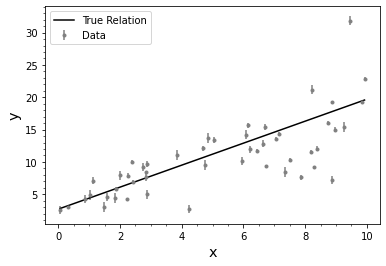

In [295]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(x, y,
            yerr=yerr,
            ls='',
            marker='.',
            color='gray',
            label='Data')
ax.plot(x, m_true*x + b_true,
        color='black',
        ls='-',
        label='True Relation')
ax.set_ylabel('y', fontsize='x-large')
ax.set_xlabel('x', fontsize='x-large')
ax.minorticks_on()
ax.legend(loc='best')

The true model is shown as the thick grey line and the effect of the underestimated uncertainties is obvious.

A typical fitting routine would be to use least-squares fitting. Since this function is a line, we can use linear least-squares, which means the parameters can technically be solved by hand using linear algebra (but why would you do that to yourself when you have a computer?).

### Least-Squares Fit

I refer you to wiki pages on linear regression and generalized least-squares, https://en.wikipedia.org/wiki/Generalized_least_squares and https://en.wikipedia.org/wiki/Linear_regression respectively, for a refresher on what the matrix notation below means. Also note that we're ignoring uncertainties in x for the moment.

In [296]:
A = np.vstack((np.ones_like(x), x)).T                       #make a matrix of x values with ones in the 1st column
C = np.diag(yerr * yerr)                                    #vectorize the uncertainties
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))     #see wiki pages
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))#calculation of solution vector
print('Least squares fitting result:')
print('slope: {0:1.2f} ± {1:.3f}'.format(m_ls, np.sqrt(cov[0, 0])))
print('y-intercept: {0:1.2f} ± {1:.3f}'.format(b_ls, np.sqrt(cov[1, 1])))

Least squares fitting result:
slope: 1.49 ± 0.117
y-intercept: 2.88 ± 0.018


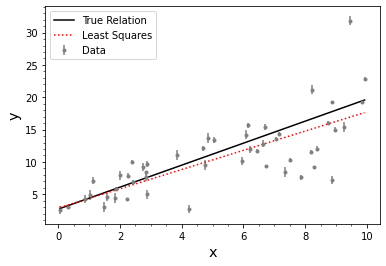

In [297]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(x, y,
            yerr=yerr,
            ls='',
            marker='.',
            color='gray',
            label='Data')
ax.plot(x, m_true*x + b_true,
        color='black',
        ls='-',
        label='True Relation')
ax.plot(x, m_ls * x + b_ls,
        color='red',
        ls=':',
        label='Least Squares')
ax.set_ylabel('y', fontsize='x-large')
ax.set_xlabel('x', fontsize='x-large')
ax.minorticks_on()
ax.legend(loc='best')

As you can see, the correspondance between the fit (red dotted line) and the true relation is believable, but depending on what the random number generator gave you, it might not be great. The reported uncertainties in the slope and intecept, as well as the error bars, also look too small given the amount scatter that's visible. You might be able to do better if you reran the preceding commands with more data (say, N=100), but of course, you don't often get that luxury for real data.

The least squares solution found in the previous section is the maximum likelihood result for a model where *the error bars are assumed to be correct, Gaussian, and independent (not correlated with y), and the variance in y is constant in x*. We know from how we constructed the model that these assumptions are wrong. There are generalizations for non-normal uncertainty distributions, but there is no generalization of linear regression that can be solved analytically if the other assumptions do not hold.

So what do we do?

### Maximum likelihood

We need to write down the likelihood function and numerically optimize it. But wait, what's a likelihood function?

Let $\theta=(m,b,f)$ represent the vector form of the parameters of our model. Then, as $y$ is the distribution of $x$ with $\theta$ fixed, so the likelihood function is the distribution of $\theta$ with $x$ fixed. (There are a lot of nuances about the statistical interpretations that I'm glossing over. Let's just say I'm not equipped to explain them, but if they matter for this, much bigger names than any of us are in trouble.) These may be helpful reading: https://www.univ-orleans.fr/deg/masters/ESA/CH/Chapter2_MLE.pdf & http://web.vu.lt/mif/a.buteikis/wp-content/uploads/PE_Book/3-4-UnivarMLE.html

In practice, it's usually easier to minimize the negative of the log of the likelihood function. For our linear model where the uncertainties are Gaussian but underestimated by some constant fraction $f$, statisticians would write this on the chalkboard:

$\ln\,p(y\,|\,x,\sigma,m,b,f) = -\frac{1}{2} \sum_n \left[\frac{(y_n-m\,x_n-b)^2}{s_n^2}
    + \ln \left ( 2\pi\,s_n^2 \right )\right]$

where

$s_n^2 = \sigma_n^2+f^2\,(m\,x_n+b)^2 \quad$.

As an aside, I googled how to know whether your parameter uncertainties are normally distributed. The short answer is that there are some calculus theorems you can use to prove that if your measurement uncertainties are not correlated with x, your parameter uncertainties will have the same distribution around the best fit parameters as your measurement uncertainties have around the best fit model. The longer answer is in that second link above.

It's not always possible to know the functional form of your parameter uncertainties, particularly with the kinds of sparsely sampled data that we're used to. In that case, we have to assume a functional form for our parameter uncertainties just so we have a distribution to sample, visualize, and check. Gaussian uncertainties are a common assumption, and a good approximation if we suspect there are a lot of smaller random factors at play (central limit theorem). The assumption breaks down in the presence of significant systematic uncertainties.

In [286]:
import scipy.optimize as op

In [298]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta #note the use of log_f. This forces f to be positive
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [299]:
# let's make some initial guesses for our parameters, again by synthetically adding noise to the true parameters

p2 = np.array([m_true, b_true, f_true]) + 0.1 * np.random.randn(3) # remember this is now theta
nll = lambda *args: -lnlike(*args)  # this just makes the log likelihood function negative so we can minimize it
# Could have easily made lnlike negative up there, but that minus sign is kind of important to keep track of.
result = op.minimize(nll,p2,args=(x, y, yerr))
if not(result['success']):
    print("Max likelihood failed.")
    print(result['message'])

ml_m, ml_b, ml_f = result['x']

In [300]:
print("Maximum likelihood result:")
print("slope: {0:1.2f}".format(ml_m))
print("y-intercept: {0:1.2f}".format(ml_b))
print("f: {0:1.2f}".format(np.exp(ml_f)))

Maximum likelihood result:
slope: 1.53
y-intercept: 2.92
f: 0.29


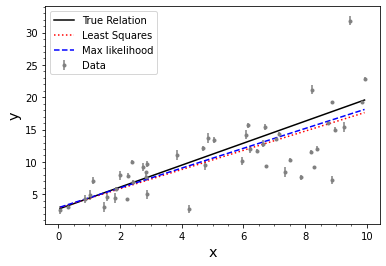

In [301]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(x, y,
            yerr=yerr,
            ls='',
            marker='.',
            color='gray',
            label='Data')
ax.plot(x, m_true*x + b_true,
        color='black',
        ls='-',
        label='True Relation')
ax.plot(x, m_ls * x + b_ls,
        color='red',
        ls=':',
        label='Least Squares')
ax.plot(x, ml_m * x + ml_b,
        color='blue',
        ls='--',
        label='Max likelihood')
ax.set_ylabel('y', fontsize='x-large')
ax.set_xlabel('x', fontsize='x-large')
ax.minorticks_on()
ax.legend(loc='best')

That blue dashed line is the result of maximum likelihood estimation (MLE). Looks better, right? (Well, not necessarily, depending on what you get from random, but this is the more mathematically rigorous way). But it's missing something...


### What about the Errors?

This is where MCMC comes in.

A statistician might write the following on the chalkboard to show you how a posterior distribution is defined without bothering with any scale factors:

$p (m,b,f\,|\,x,y,\sigma) \propto p(m,b,f)\,p(y\,|\,x,\sigma,m,b,f) \quad .$

The posterior distribution is the probability of the model (m,b,f) given the data (x,y,$\sigma$). As we saw above, $p(y\,|\,x,\sigma,m,b,f)$ is the likelihood function. That just leaves $p(m,b,f)$, which is called the prior function. Anything you know about those parameters from, say, theory or other experiments, you have to try to encapsulate in this term.

Priors are necessary for MCMC because all that MCMC does is draw samples from a probability distribution and you want that to be a probability distribution for your parameters. **This is important: you cannot draw parameter samples from your likelihood function.** This is because a likelihood function is a probability distribution over datasets so, conditioned on model parameters, you can draw representative datasets (as demonstrated at the beginning of this exercise) but you cannot draw parameter samples.

Sometimes all you can do is tell your prior function where your parameters aren't. From the plot above, we can tell a few things about m, b, and f: all are >0, b<5, and m<3. We'll define our prior to be equal to zero outside those ranges and a constant inside (it doesn't much matter what the constant is). Again, you actually want to work in log-space here.

In [309]:
def lnprior(theta):
    m, b, lnf = theta
    if 0 < m < 3. and 0.0 < b < 5.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

Combining this with the definition of log likelihood from above, the full log-probability function is:

In [310]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

Now we set up the MCMC chains. The sampler (actually, a lot of samplers running in parallel) will do a random walk around the parameter space specified by the priors, starting from your choice of initial values. We'll initialize all the walkers to approximately the results of our MLE, plus a little deviation so they don't take quite as long to get out and explore.

In [311]:
ndim = len(result["x"])
nwalkers = 100
steps = 3000
pos = [result["x"] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [312]:
# initialze the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x,y,yerr))

https://www.youtube.com/watch?v=xSLlZh9yelk

In [313]:
# Run, Forrest, Run!
# run the sampler for 500 steps
sampler.run_mcmc(pos, steps, progress=True) #progress=True prints a progress bar
samples = sampler.chain

100%|██████████| 3000/3000 [00:15<00:00, 188.82it/s]


What is the acceptance rate? The ideal varies from distribution to distribution, but literature has it that this should be 23% to 50% to maximize efficiency.

In [314]:
print("Mean acceptance rate is: {0:1.2f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance rate is: 0.65


This acceptance rate is okay. If it is too low, the emcee documentation suggests increasing the number of walkers until the acceptance fraction is at the desired level. If it's too high, see if you can narrow your priors bit or reduce the number of walkers.

Now let's visualize the time series of the parameters in the chains so we can see what was happening under the hood. The samples can be accessed using the EnsembleSampler().get_chain() method. This will return an array giving the parameter values for each walker at each step in the chain. The figure below shows the positions of each walker as a function of the number of steps in the chain:

(3000, 100, 3)


Text(0.5, 0, 'step number')

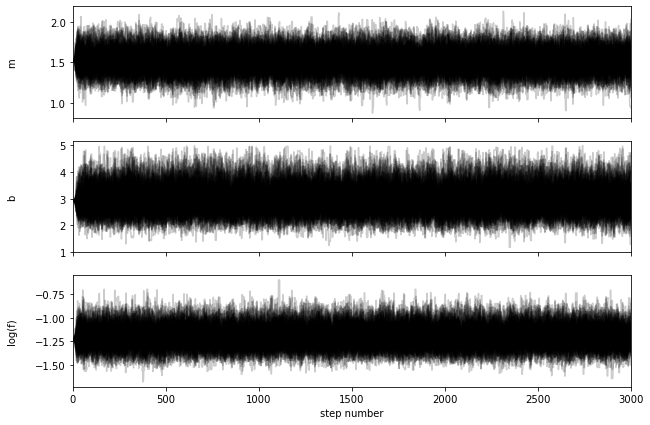

In [315]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print(np.shape(samples))
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.2)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

As expected, the walkers started in small distributions around the maximum likelihood values and then quickly wandered out to start exploring the full posterior distribution. In fact, the "burn-in phase" is so brief it's hard to see; it must be fewer than 50 steps. We can look at an estimate of the integrated autocorrelation time (more like the autocorrelation length; see https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#autocorr for more details) to see how many steps are actually needed for the chain to “forget” where it started:

In [316]:
tau = sampler.get_autocorr_time()
print(tau)

[34.72796471 34.84714145 33.87092284]


That's the minimum number of steps you should discard from the beginning of your sampler chain, but 50 is a nice round number and close enough.

(Note: in the course of tinkering with the numbers of chains and walkers, I've discovered that if the chain length is <50x the integrated autocorrelation time, an AutocorrError message will print telling me to use a longer chain.)

Now that we have this list of samples, let’s make one of the most useful plots you can make with your MCMC results: a corner plot. Here's where you’ll need the corner.py module. Once you have it, generating a corner plot is fairly trivial. Corner.corner comes with all sorts of handy kwargs to view relevant stats and comparisons right on the plot. We can use the "truths" parameter to see how our results compare to the actual values.

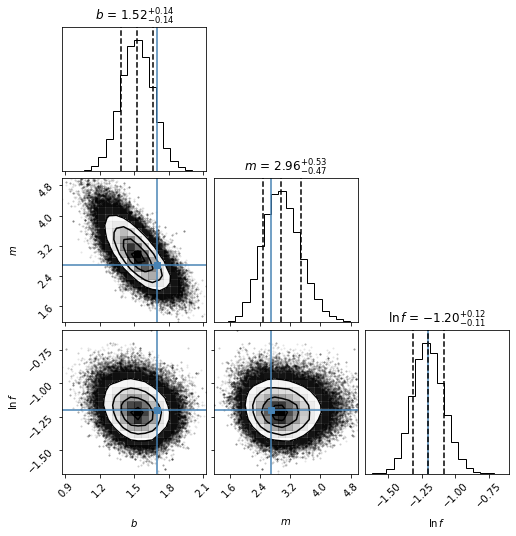

In [317]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
fig = corner.corner(samples,
                    labels=[r"$b$", r"$m$", r"$\ln\,f$"],
                    quantiles=[0.16, 0.5, 0.84], #these correspond to the mean and 1 sigma to either side 
                    truths=[m_true, b_true, np.log(f_true)],
                    show_titles=True)

If the truth values look far from the means, it's because the parameter space that the MCMC routine can explore is only as representative as your measurements are of the true distribution. If your sample size is small, as this example was, it's less likely to be representative of the whole distribution. That's the risk we run with small number statistics. 

What's really cool about these corner plots is that these are marginal distributions: probability distributions of each parameter with dependencies on other parameters eliminated by summing over their distributions (see https://en.wikipedia.org/wiki/Marginal_distribution). The 1-D histograms are the marginal distributions for the title parameter alone, and the 2D histograms are the marginal distributions of the two parameters on each axis independent of the third parameter. This is how you can isolate unknown nuisance parameters (in this case f).

**A note on the percentiles and levels: the quantiles on the 1D histograms the the levels on the 2D histograms represent the same sigma levels, but they do not enclose the same percentage of data (see https://corner.readthedocs.io/en/latest/pages/sigmas.html). The quantiles only apply to the 1D histograms, which are marginal distributions for each parameter once every other parameter is marginalized out such that sigma can only be measured in 1 dimension. These are the sigmas you should report when reporting the best fit parameter values and their uncertainties.**

Now let's plot a bunch of sample fits from the MCMC chain, on top of our data and other models to see how the variance in the model parameters looks on the original plot.

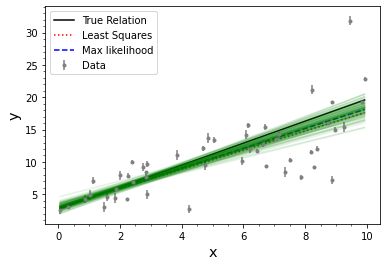

In [318]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(x, y,
            yerr=yerr,
            ls='',
            marker='.',
            color='gray',
            label='Data')
ax.plot(x, m_true*x + b_true,
        color='black',
        ls='-',
        label='True Relation')
ax.plot(x, m_ls * x + b_ls,
        color='red',
        ls=':',
        label='Least Squares')
ax.plot(x, ml_m * x + ml_b,
        color='blue',
        ls='--',
        label='Max likelihood')
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(x,
            m * x + b,
            color='green',
            alpha=0.1)
ax.set_ylabel('y', fontsize='x-large')
ax.set_xlabel('x', fontsize='x-large')
ax.minorticks_on()
ax.legend(loc='best')

In [319]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print("MCMC Parameter estimates:")
print("slope: {0:1.2f} (+{1:1.2f}, -{2:1.2f})".format(m_mcmc[0],
                                                        m_mcmc[1],
                                                        m_mcmc[2]))
print("y-intercept: {0:1.2f} (+{1:1.2f}, -{2:1.2f})".format(b_mcmc[0],
                                                        b_mcmc[1],
                                                        b_mcmc[2]))
print("\nTrue values:")
print("slope: {0:1.2f}".format(m_true))
print("y-intercept: {0:1.2f}".format(b_true))

MCMC Parameter estimates:
slope: 1.52 (+0.14, -0.14)
y-intercept: 2.96 (+0.53, -0.47)

True values:
slope: 1.70
y-intercept: 2.70


## Astrophysical Example: FIR SED

Let's say we have Herschel PACS+SPIRE photometry (and SCUBA-850 data just to make sure we can fit beta) and we want to get the dust temperature. I'm going to use a bit of my own data from one of our Cygnus-X objects, N12, and we're going to make the dubious assumtion of optically thin dust emission for simplicity ($\tau$ actually gets fairly close to 1 at 70 microns if you use the Ossenkopf & Henning opacity table). The distance to this object is assumed to be 1.4 kpc.

(You can delete blackbody.py. They fiddled with the units sometime after the original version of this tutorial was written and I couldn't salvage it. I ripped an even simpler version from https://github.com/SKIRT/PTS/blob/master/core/basics/greybody.py)

In [320]:
FIRm = np.array([(70., 134.,16.),
                 (160., 230.,14.),
                 (250., 163.,9.),
                 (350., 99., 8.),
                 (500., 53., 4.),
                 (850., 11., 4.)],
                dtype=[('wave', float),
                       ('flux', float),
                       ('dflux', float)])
plotrange = np.arange(FIRm['wave'][0],
                      FIRm['wave'][-1],
                      1)

In [322]:
# universal constants and units
c = 2.99792458e8        # m/s
h = 6.62606957e-34      # J s
k = 1.3806488e-23       # J/K
pc = 3.08567758e16      # m
Msun = 1.9891e30        # kg

# typical opacities at 350 micron
kappa350_OH = 0.78   # m2/kg (Ossenkopf & Henning) <--I use this one; they assume beta = 1.8
kappa350_Zubko = 0.330     # m2/kg (Zubko)
# typical gas-to-dust ratios:
g2d_zubko = 166.
g2d_draine = 132.
g2d_beckw = 100.

## This static function returns the black body emissivity \f$B_\nu\f$ (W/m2/Hz) for the specified wavelength or
# wavelengths \em wave (micron), and for the given dust temperature \em T (K).
def Bnu(wave, T):
    nu = c / (wave*1e-6)                                    # Hz
    Bnu = 2*h*nu**3/ c**2 / (np.exp((h*nu)/(k*T)) - 1)      # W/m2/Hz
    return Bnu

## This static function returns the grey body flux (Jy) for the specified wavelength or wavelengths \em wave (micron),
# for the given observer distance \em D (pc), power-law exponent \em beta, opacity \em kappa at 350 micron (m2/kg),
# dust temperature \em T (K) and gas mass \em M (Msun).
def greybody(D, kappa350, wave, T, M, beta):
    nu = c / (wave*1e-6)                                    # Hz
    nu350 = c / 350e-6                                      # Hz
    g2d = g2d_beckw
    kappa = kappa350 * (nu/nu350)**beta                     # m2/kg
    Bnu = 2*h*nu**3/ c**2 / (np.exp((h*nu)/(k*T)) - 1)      # W/m2/Hz
    flux = M*Msun * kappa * Bnu / ((D*pc)**2  * g2d)        # W/m2/Hz
    return flux * 1e26                                      # Jy
# ----------------------------------------------------------------------

def fit_bb(wav, T, M, beta):
    return greybody(1400., kappa350_OH, wav, T, M, beta)

We're going to again assume Gaussian uncertainties because we don't really know any better.

In [323]:
def lnlike(theta, x, y, yerr):
    T, M, beta, lnf = theta
    model = fit_bb(x, T, M, beta)
    inv_sigma2 = 1.0 / (yerr**2 + model**2*np.exp(2*lnf))
    return -0.5 * np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2))

In [325]:
# initial guesses. 25K, fairly large mass 
p0 = [25., 50., 1.8, -1]
nll = lambda *args: -lnlike(*args)
maxlike = op.minimize(nll, p0,
                      args=(FIRm['wave'],
                            FIRm['flux'],
                            FIRm['dflux']))
Tfit, Mfit, betafit, lnffit = maxlike["x"] 
print("Max likelihood:")
print("T: {0:1.1f} K".format(Tfit))
print("M: {0:2.1f}".format(Mfit))
print("beta: {0:1.2f}".format(betafit))
print("f: {0:1.2e}".format(np.exp(lnffit)))

Max likelihood:
T: 34.7 K
M: 28.2
beta: 0.35
f: 1.14e-05


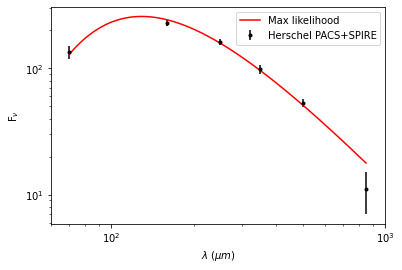

In [326]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(FIRm['wave'],
            FIRm['flux'],
            yerr=FIRm['dflux'],
            ls='',
            marker='.',
            color='black',
            label='Herschel PACS+SPIRE')
ax.plot(plotrange,
        fit_bb(plotrange,
               Tfit,
               Mfit,
               betafit),
        color='red',
        label='Max likelihood')
ax.set_ylabel(r'F$_{\nu}$')
ax.set_xlabel('$\lambda$ ($\mu m$)')
ax.set_xlim([60, 1000])
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc='best')

### MCMC

This will show how you might use informative priors.

First of all, we know all the parameters are positive. We can readily see that the peak is between 70 and 250 microns; from Wien's displacement law, that means 12 K < T < 41 K. The temperatures in that range are not equally probable. Let's further say we know from a different experiment using a different fitting technique that this particular object is believed to have a temperature of $25\pm4$ K, and incorporate that into our prior (note that we don't have to incorporate any constants from the equation for a Gaussian distribution; only the relative probabilities matter). This is a high-mass star forming region, so M is probably substantially greater than a solar mass, but we don't really have a good upper limit because the measured mass will include an envelope that may be much larger than the protostar or any eventual star. Let's say 1<M<1000, and let that be flat. Beta is supposed to be between 1. and 2.5, but that's not looking so good as a constraint given our MLE. Let's say the same other experiment used to give us that temperature prior also told us that beta has a mean of 1.2 and a dispersion of 0.2.

In [327]:
def lnprior(theta):
    T, M, beta, lnf = theta
    if 12. <=T <= 41. and 1 < M < 1000. and beta > 0. and -15<lnf<2.:
        return -1 * (T - 25.)**2 / (2 * 4.**2) - 1 * (beta - 1.2)**2 / (2 * 0.2**2)
    return -np.inf 

In [328]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not(np.isfinite(lp)):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [329]:
ndim, nwalkers = 4, 400
pos = [maxlike["x"] + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

Because of the larger parameter space and more complex model, we'll need more walkers, more steps, and more time to run.

In [330]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,
                                args=(FIRm['wave'],
                                      FIRm['flux'],
                                      FIRm['dflux']))
                                #threads=nthreads)
sampler.run_mcmc(pos, 4000, progress=True)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

100%|██████████| 4000/4000 [02:04<00:00, 32.01it/s]


Again, look at the distribution of parameter estimates. But here, show the estimated parameters from the maximum likelihood model as the "true" values.

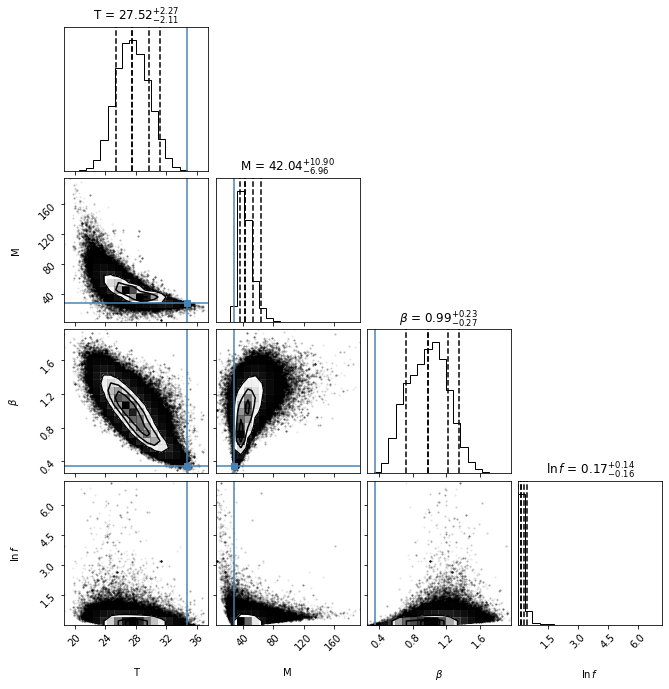

In [338]:
# show best-fit values as the "truth" values
fig = corner.corner(samples,
                    labels=["T", "M", r"$\beta$", r"$\ln\,f$"],
                    quantiles=[0.5, 0.16, 0.5, 0.84, 0.95],
                    #levels=(1-np.exp(-0.5), ),
                    show_titles=True,
                    truths=[Tfit, Mfit, betafit, lnffit])

The offsets between the MCMC median values and the maximum likelihood are at least partially a consequence of our chosen priors. Clearly the assumption of Gaussian priors wasn't a good one. Additionally, the nuisance parameter f appears not to be defined in a way that helps parameterize our ignorance (at least that's my interpretation - if anyone has alternative or additional explanations to offer, chime in now).

Let's plot some models on our data.

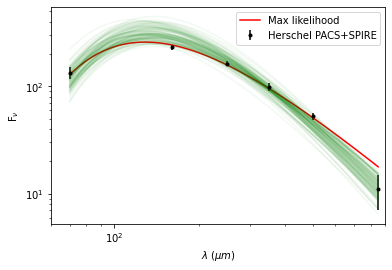

In [333]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(FIRm['wave'],
            FIRm['flux'],
            yerr=FIRm['dflux'],
            ls='',
            marker='.',
            color='black',
            label='Herschel PACS+SPIRE')
ax.plot(plotrange,
        fit_bb(plotrange,
               Tfit,
               Mfit,
               betafit),
        color='red',
        label='Max likelihood')
for T, M, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(plotrange,
            fit_bb(plotrange, T, M, b),
            color='green',
            alpha=0.05)
ax.set_ylabel(r'F$_{\nu}$')
ax.set_xlabel('$\lambda$ ($\mu m$)')
ax.set_xlim([60, 900])
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc='best')

In [335]:
samples[:, 3] = np.exp(samples[:, 3])
T_mcmc, A_mcmc, beta_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                       zip(*np.percentile(samples, [16, 50, 84],
                                                          axis=0)))
print("MCMC Parameter estimates:")
print("T: {0:1.2f} (+{1:1.2f}, -{2:1.2f}) K".format(T_mcmc[0],
                                                  T_mcmc[1],
                                                  T_mcmc[2]))
print("beta: {0:1.2f} (+{1:1.2f}, -{2:1.2f})".format(beta_mcmc[0],
                                                     beta_mcmc[1],
                                                     beta_mcmc[2]))

MCMC Parameter estimates:
T: 27.52 (+2.27, -2.11) K
beta: 0.99 (+0.23, -0.27)


It is left to as an exercise to the reader to re-run the blackbody fitting with flat priors on the temperature or beta and see how that changes the resulting fits.